## Import and install library

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2425 sha256=4e08b50380de9fc327888de40579111c9aa43bd828ea8fd8f8b5b7e264a5acd7
  Stored in directory: /root/.cache/pip/wheels/54/1d/51/d65a99106096dd07e3be6f08d5d3c2dd5f26ac98f626e5efc9
Successfully built colabgymrender


In [3]:
from colabgymrender.recorder import Recorder

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



In [4]:
# install dependencies
!apt install chromium-browser xvfb

  and should_run_async(code)



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfontenc1 libfuse3-3 liblzo2-2 libudev1 libxfont2 libxkbfile1 snapd squashfs-tools
  systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfontenc1 libfuse3-3 liblzo2-2 libxfont2 libxkbfile1 snapd
  squashfs-tools systemd-hwe-hwdb udev x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
The following packages will be upgraded:
  libudev1
1 upgraded, 17 newly installed, 0 to remove and 44 not upgraded.
Need to get 36.2 MB of archives.
After this operation, 129 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.3 [595 kB]


## Function

Define NeuralNetwork

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [6]:
class NeuralNetwork_2(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork_2, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

DQN Training Function

In [7]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [8]:
def dqn_training_2(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork_2(env)
    target_net = NeuralNetwork_2(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

Fill memory Function

In [9]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

## Test Experiment with CartPole-v0

In [10]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  logger.warn(

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



72.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [11]:
total_reward

  and should_run_async(code)



72.0

In [12]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [13]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  states = torch.tensor(states, dtype=torch.float32)



Episode: 42 Step: 1000 Average reward: 23.69047619047619
Episode: 85 Step: 2000 Average reward: 23.352941176470587
Episode: 120 Step: 3000 Average reward: 25.35
Episode: 157 Step: 4000 Average reward: 25.61
Episode: 186 Step: 5000 Average reward: 29.78
Episode: 211 Step: 6000 Average reward: 32.93
Episode: 224 Step: 7000 Average reward: 37.56
Episode: 235 Step: 8000 Average reward: 45.3
Episode: 242 Step: 9000 Average reward: 53.24
Episode: 247 Step: 10000 Average reward: 61.27
Episode: 252 Step: 11000 Average reward: 69.66
Episode: 258 Step: 12000 Average reward: 79.72
Episode: 263 Step: 13000 Average reward: 88.02
Episode: 268 Step: 14000 Average reward: 96.11
Episode: 273 Step: 15000 Average reward: 104.56
Episode: 278 Step: 16000 Average reward: 112.54
Episode: 283 Step: 17000 Average reward: 120.81
Episode: 288 Step: 18000 Average reward: 129.08
Episode: 293 Step: 19000 Average reward: 137.88
Episode: 298 Step: 20000 Average reward: 146.56
Episode: 303 Step: 21000 Average reward: 

  and should_run_async(code)



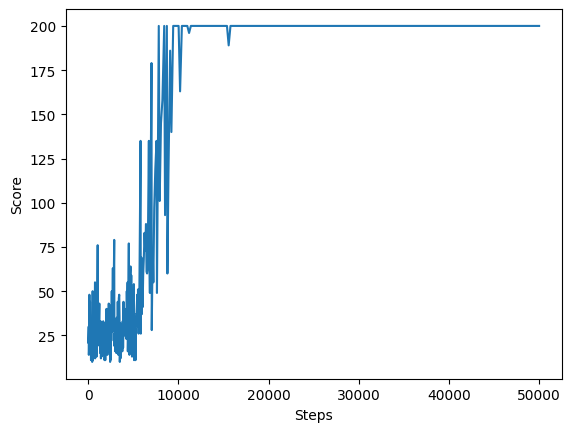

In [14]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [15]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Experiment with MountainCar-v0

In [10]:
env = gym.make('MountainCar-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



-200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [16]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.001
max_num_steps = 200000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 9e-4 # learning rate

memory_size = 100000
min_replay_size = 1000
batch_size = 256

target_update_frequency = 1000 # target network update frequency

In [17]:
all_rewards, q_net = dqn_training_2(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -200.0
Episode: 60 Step: 12000 Average reward: -200.0
Episode: 65 Step: 13000 Average reward: -200.0
Episode: 70 Step: 14000 Average reward: -200.0
Episode: 75 Step: 15000 Average reward: -200.0
Episode: 80 Step: 16000 Average reward: -199.4
Episode: 85 Step: 17000 Average reward: -199.2941176470588
Episode: 90 Step: 18000 Average reward: -199.25555555555556
Episode: 95 Step: 19000 Average reward: -199.29473684210527
Episode: 100 Step: 20000 Average reward: -198.98
Episode: 105 Step: 21000 Avera

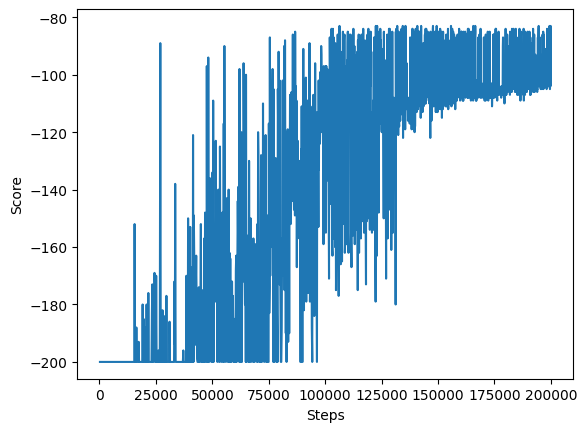

In [18]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [21]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-83.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [23]:
statistics = []

  and should_run_async(code)



In [24]:
for i in range(0, 10):
  env = Recorder(env, './video')
  state = env.reset()
  done = False
  total_reward = 0.0
  q_net.eval()

  with torch.no_grad():
      while not done:
          #action = env.action_space.sample()
          action = q_net.choose_action(state)
          next_state, reward, done, info = env.step(action)
          total_reward += reward
          state = next_state
  statistics.append(total_reward)
  print(total_reward)
  env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-84.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-86.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-93.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-95.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-92.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-84.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-106.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  84%|████████▍ | 91/108 [00:00<00:00, 304.30it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717744169.6289272.mp4, 720000 bytes wanted but 0 bytes read,at frame 107/108, at time 3.57/3.57 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-91.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  69%|██████▉   | 64/93 [00:00<00:00, 315.16it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717744187.6129386.mp4, 720000 bytes wanted but 0 bytes read,at frame 92/93, at time 3.07/3.07 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-94.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  98%|█████████▊| 94/96 [00:00<00:00, 312.99it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717744205.7675378.mp4, 720000 bytes wanted but 0 bytes read,at frame 95/96, at time 3.17/3.17 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



Moviepy - Done !
Moviepy - video ready __temp__.mp4


See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-85.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:  72%|███████▏  | 63/87 [00:00<00:00, 315.48it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./video/1717744222.333657.mp4, 720000 bytes wanted but 0 bytes read,at frame 86/87, at time 2.87/2.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+

                                                             

Moviepy - Done !
Moviepy - video ready __temp__.mp4


## Comment

In [ ]:
print("Mean of Reward MountainCar-v0 in 10 tries: ", sum(statistics)/len(statistics))

Mean of Reward MountainCar-v0 in 10 tries:  -91.0


&nbsp;&nbsp;  In the process of experimenting many times, I have some changes as follows:

*   Reduce min epsilon to **0.001**
*   Increase learning_rate to **9e-4**
*   Increase the number of loops to **200000**
*   Increase batch size to **128**
*   Increase memory size to **100000**
*   Change activation function: **nn.ReLU()** 
*   Change Neural network architecture: add **Linear layer** and input shape = (128,128), add activation function **nn.Sigmoid()**

&nbsp;&nbsp; After many rounds of hyperparameter tuning and changes to the network architecture, the model for MountainCar-v0 seems to have almost learned how to reach the destination using the given weights. However, the best score I can achieve is a reward of **-83.0**. The video is **2** seconds long. I also tried to compute the mean reward by having it play 10 times repeatedly, and the mean value ranged from **-91.0** to **-98.0**